In [37]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter

# import dataset
from torch_geometric.datasets import GitHub

dataset = GitHub(root='/tmp/GitHub')
graph = dataset[0]

# graph.x  # Node features, already in 1x128 for each node
# graph.edge_index  # edge_index shape: 2xNe
# graph.y  #  Labels

In [60]:
# split the data

split = T.RandomNodeSplit(num_val=0.2, num_test=0.1)
graph = split(graph)  # resetting data split
print(
    f"train: {int(graph.train_mask.sum())}, ",
    f"val: {int(graph.val_mask.sum())}, ",
    f"test: {int(graph.test_mask.sum())}",
)

train: 26390,  val: 7540,  test: 3770


In [59]:
import random

def sample_data(graph, num_val=0.2, num_test=0.1):
    N = graph.x.shape[0]
    N_0 = (graph.y == 0).sum()
    N_1 = N - N_0
    
    num_train = 1-num_val-num_test
    N_train = int(N*num_train)
    if N_train//2 < N_0 or N_train//2 < N_1:
        print('Please set num_val greater')
        return graph
    
    Idx = torch.tensor(range(N))
    Idx_0 = Idx[graph.y==0]
    Idx_1 = Idx[graph.y==1]
    
    a = random.sample(Idx_0, N_train//2)
    b = random.sample(Idx_1, N_train//2)
    
    graph.train_mask = [False]*N
    graph.train_mask[a] = True
    graph.train_mask[b] = True


In [3]:
# functions to train and eval a model

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=100):
    model.history_acc_val = []
    model.history_loss_val = []
    model.history_acc_train = []
    model.history_loss_train = []
    
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss_train = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss_train.backward()
        optimizer.step()
        pred = out.argmax(dim=1)
        acc_val = eval_node_classifier(model, graph, graph.val_mask)
        acc_train = eval_node_classifier(model, graph, graph.train_mask)
        loss_val = criterion(out[graph.val_mask], graph.y[graph.val_mask])
        
        model.history_acc_val.append(acc_val)
        model.history_loss_val.append(loss_val.item())
        model.history_acc_train.append(acc_train)
        model.history_loss_train.append(loss_train.item())
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss_train:.3f}, Val Acc: {acc_val:.3f}')
    return model

def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc

In [71]:
# Model 1: Graph Convolutional Neural Network

from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = GCNConv(dataset.num_node_features, 32) # hidden layer
        self.conv2 = GCNConv(32, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        output = F.softmax(x,dim=1)

        return output

In [72]:
# Model 2: MLP as baseline

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(dataset.num_node_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32), 
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
        )

    def forward(self, data):
        x = data.x  # only using node features (x)
        x = self.layers(x)
        output = F.softmax(x,dim=1)
        return output

In [76]:
# start training

# calculating the weights of 0 and 1 in the training set
# num_0_1 = graph.train_mask.sum()
# num_1 = graph.y[graph.train_mask].sum()
# r_1 = num_1/num_0_1
# r_0 = 1-r_1

weights = torch.tensor([0.5,0.5])

print('---GNN start---')
gcn = GCN()
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=weights)
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion, n_epochs=100)
print('---GNN end---')

print('---MLP start---')
mlp = MLP()
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.1, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=weights)
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=100)
print('---MLP end---')

---GNN start---
Epoch: 010, Train Loss: 0.428, Val Acc: 0.828
Epoch: 020, Train Loss: 0.395, Val Acc: 0.828
Epoch: 030, Train Loss: 0.388, Val Acc: 0.840
Epoch: 040, Train Loss: 0.386, Val Acc: 0.845
Epoch: 050, Train Loss: 0.386, Val Acc: 0.847
Epoch: 060, Train Loss: 0.385, Val Acc: 0.846
Epoch: 070, Train Loss: 0.385, Val Acc: 0.845
Epoch: 080, Train Loss: 0.385, Val Acc: 0.846
Epoch: 090, Train Loss: 0.384, Val Acc: 0.846
Epoch: 100, Train Loss: 0.384, Val Acc: 0.846
---GNN end---
---MLP start---
Epoch: 010, Train Loss: 0.417, Val Acc: 0.742
Epoch: 020, Train Loss: 0.417, Val Acc: 0.742
Epoch: 030, Train Loss: 0.417, Val Acc: 0.742
Epoch: 040, Train Loss: 0.390, Val Acc: 0.829
Epoch: 050, Train Loss: 0.384, Val Acc: 0.832
Epoch: 060, Train Loss: 0.383, Val Acc: 0.841
Epoch: 070, Train Loss: 0.381, Val Acc: 0.836
Epoch: 080, Train Loss: 0.379, Val Acc: 0.838
Epoch: 090, Train Loss: 0.386, Val Acc: 0.827
Epoch: 100, Train Loss: 0.382, Val Acc: 0.807
---MLP end---


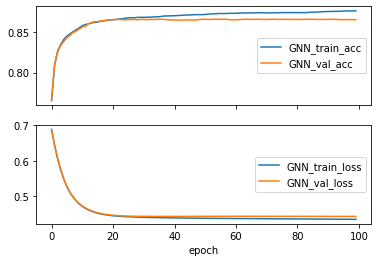

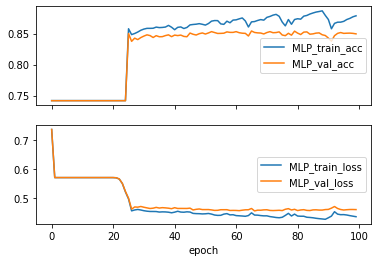

In [74]:
# show training results

from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, sharex='col', sharey='row')
ax[0].plot(gcn.history_acc_train)
ax[0].plot(gcn.history_acc_val)


ax[1].plot(gcn.history_loss_train)
ax[1].plot(gcn.history_loss_val)
plt.xlabel('epoch')
ax[0].legend(['GNN_train_acc', 'GNN_val_acc'], loc='center right')
ax[1].legend(['GNN_train_loss', 'GNN_val_loss'], loc='center right')
plt.show()

fig, ax = plt.subplots(2, sharex='col', sharey='row')
ax[0].plot(mlp.history_acc_train)
ax[0].plot(mlp.history_acc_val)


ax[1].plot(mlp.history_loss_train)
ax[1].plot(mlp.history_loss_val)
plt.xlabel('epoch')
ax[0].legend(['MLP_train_acc', 'MLP_val_acc'], loc='center right')
ax[1].legend(['MLP_train_loss', 'MLP_val_loss'], loc='center right')
plt.show()
